### Data viewing
Let's see what format the predicted data is 

In [32]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os

import math
from pytorch_pretrained_bert import BertTokenizer
os.chdir('../')
from modeling_readmission import BertForSequenceClassification
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

11/18/2022 02:11:36 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\user\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [35]:
pwd

'D:\\myPython'

In [58]:
import pandas as pd
sample = pd.read_csv('./Raymond Practice/clinicalBERT-master/BERT/sample.csv')
sample

,TEXT,ID,Label
0,Nursing Progress Note 1900-0700 hours:\n** Ful...,176088,1
1,Nursing Progress Note 1900-0700 hours:\n** Ful...,135568,1
2,"NPN:\n\nNeuro: Alert and oriented X2-3, Sleepi...",188180,0
3,RESPIRATORY CARE:\n\n35 yo m adm from osh for ...,110655,0
4,"NEURO: A+OX3 pleasant, mae, following commands...",139362,0
5,Nursing Note\nSee Flowsheet\n\nNeuro: Propofol...,176981,0


We can see that several pieces of unstructured text data are stored under the TEXT field, let's take one out to see what it is.

In [59]:
text = sample['TEXT'][0]
print(text)

Nursing Progress Note 1900-0700 hours:
** Full code

** allergy: nkda

** access: #18 piv to right FA, #18 piv to right FA.

** diagnosis: angioedema

In Brief: Pt is a 51yo F with pmh significant for: COPD, HTN, diabetes insipidus, hypothyroidism, OSA (on bipap at home), restrictive lung disease, pulm artery hypertension attributed to COPD/OSA, ASD with shunt, down syndrome, CHF with LVEF >60%. Also, 45pk-yr smoker (quit in [**2112**]).

Pt brought to [**Hospital1 2**] by EMS after family found with decreased LOC.  Pt presented with facial swelling and mental status changes. In [**Name (NI) **], pt with enlarged lips and with sats 99% on 2-4l.  Her pupils were pinpoint so given narcan.  She c/o LLQ abd pain and also developed a severe HA.  ABG with profound resp acidosis 7.18/108/71.  Given benadryl, nebs, solumedrol. Difficult intubation-req'd being taken to OR to have fiberoptic used.  Also found to have ARF.  On admit to ICU-denied pain in abdomen, denied HA.  Denied any pain. Pt u

**Text content**  
It can be seen that it is an ICU nursing diary. It is a 51-year-old woman with chronic obstructive pulmonary disease, hypertension, hypothyroidism, Down syndrome, congenital atrial defect, chronic heart failure, pulmonary hypertension, and sleep apnea syndrome. disease and many other diseases. After being found unconscious by family members, he was sent to the hospital because of a severe allergic reaction and acute angioedema. Slightly conscious under sedation. During the course of treatment, she suffered from hypercoagulation, lysolysis and acute renal failure.

### Model reasoning

In [60]:
import csv
import pandas as pd


class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""
    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file = pd.read_csv(input_file)
        lines = zip(file.ID, file.TEXT, file.Label)
        return lines

**Define data reading and processing classes**  
inherit from base class

In [61]:
def create_examples(lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
        guid = "%s-%s" % (set_type, i)
        text_a = line[1]
        label = str(int(line[2]))
        examples.append(
            InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples


class ReadmissionProcessor(DataProcessor):
    def get_test_examples(self, data_dir):
        return create_examples(
            self._read_csv(os.path.join(data_dir, "sample.csv")), "test")

    def get_labels(self):
        return ["0", "1"]

### Define the scaffolding function
- truncate_seq_pair
- convert_examples_to_features
- vote_score
- pr_curve_plot
- vote_pr_curve

In [62]:
# Intercept the corpus according to the maximum length
def truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [63]:
# Load the file and convert it to a tensor
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


In [64]:
# Accuracy curve and plotting
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def vote_score(df, score, ax):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    return fpr, tpr, df_out

In [65]:
from sklearn.metrics import precision_recall_curve
from funcsigs import signature


def pr_curve_plot(y, y_score, ax):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall, precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    ax.step(recall, precision, color='b', alpha=0.2,
             where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve: AUC={0:0.2f}'.format(
        area))

In [66]:
def vote_pr_curve(df, score, ax):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values

    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data=list(zip(precision, recall, thres)), columns=['prec', 'recall', 'thres'])

    pr_curve_plot(y, temp, ax)

    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()

    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print(f'Recall at Precision of 80 is {rp80}')

    return rp80

### Configure inference parameters
- output_dir: directory for output files
- task_name: task name
- bert_model: model directory
- data_dir: data directory, the default file name is sample.csv
- max_seq_length: maximum string sequence length
- eval_batch_size: The size of the inference batch, the larger the size, the larger the memory

In [69]:
config = {
    "local_rank": -1,
    "no_cuda": False,
    "seed": 42,
    "output_dir": './result',
    "task_name": 'readmission',
    "bert_model": './Raymond Practice/clinicalBERT-master/BERT/early_readmission',
    "fp16": False,
    "data_dir": './Raymond Practice/clinicalBERT-master/BERT',
    "max_seq_length": 512,
    "eval_batch_size": 2,
}


### perform reasoning  
The inference process will generate a lot of logs, you can hide the log output by selecting the current cell (the left side of the cell will turn blue after selection) and pressing the "O" key on the keyboard.

In [70]:
import random
from tqdm import tqdm
from pytorch_pretrained_bert.tokenization import BertTokenizer
from modeling_readmission import BertForSequenceClassification
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch

 

processors = {
    "readmission": ReadmissionProcessor
}

if config['local_rank'] == -1 or config['no_cuda']:
    device = torch.device("cuda" if torch.cuda.is_available() and not config['no_cuda'] else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", config['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device %s n_gpu %d distributed training %r", device, n_gpu, bool(config['local_rank'] != -1))


random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
if n_gpu > 0:
    torch.cuda.manual_seed_all(config['seed'])


if os.path.exists(config['output_dir']):
    pass
else:
    os.makedirs(config['output_dir'], exist_ok=True)

task_name = config['task_name'].lower()

if task_name not in processors:
    raise ValueError(f"Task not found: {task_name}")

processor = processors[task_name]()
label_list = processor.get_labels()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare model
model = BertForSequenceClassification.from_pretrained(config['bert_model'], 1)
if config['fp16']:
    model.half()
model.to(device)
if config['local_rank'] != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config['local_rank']],
                                                      output_device=config['local_rank'])
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

eval_examples = processor.get_test_examples(config['data_dir'])
eval_features = convert_examples_to_features(
    eval_examples, label_list, config['max_seq_length'], tokenizer)
logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", config['eval_batch_size'])
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
if config['local_rank'] == -1:
    eval_sampler = SequentialSampler(eval_data)
else:
    eval_sampler = DistributedSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=config['eval_batch_size'])
model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
true_labels = []
pred_labels = []
logits_history = []
m = torch.nn.Sigmoid()
for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)
    with torch.no_grad():
        tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    logits = torch.squeeze(m(logits)).detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()

    outputs = np.asarray([1 if i else 0 for i in (logits.flatten() >= 0.5)])
    tmp_eval_accuracy = np.sum(outputs == label_ids)

    true_labels = true_labels + label_ids.flatten().tolist()
    pred_labels = pred_labels + outputs.flatten().tolist()
    logits_history = logits_history + logits.flatten().tolist()

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

11/18/2022 02:42:17 - INFO - __main__ -   device cpu n_gpu 0 distributed training False
11/18/2022 02:42:18 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\user\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/18/2022 02:42:18 - INFO - modeling_readmission -   loading archive file ./Raymond Practice/clinicalBERT-master/BERT/early_readmission
11/18/2022 02:42:18 - INFO - modeling_readmission -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

11/18/2022 02:42:25 - INFO - __main__

11/18/2022 02:42:25 - INFO - __main__ -   input_ids: 101 8329 5082 3602 5141 1011 5718 8889 2847 1024 1008 1008 2440 3642 1008 1008 2035 24395 1024 10047 24979 1008 1008 3229 1024 2157 9353 14255 2615 1010 2187 2192 14255 2615 11265 10976 1024 1037 1004 1051 1060 2509 1012 2583 2000 3582 2035 10954 1012 18960 11251 1012 1039 1013 1051 19935 3255 1013 19029 2226 2023 2572 1011 19960 17872 2007 2019 4371 11368 1012 7771 2087 1997 2305 1012 15050 1024 24978 2099 1011 2358 2007 4678 26189 2278 1005 1055 1012 4862 2638 2872 2000 2157 10958 2094 1012 11113 2361 2531 1011 20311 1012 4949 1005 1055 1028 3438 1012 3764 2007 2852 1031 1008 1008 2197 2171 1006 2358 4183 2571 1007 1008 1008 1033 2055 2825 2342 2005 3623 1999 22861 1012 2006 6005 18155 4747 2012 2278 1011 2445 1060 1015 13004 4921 2197 3944 2349 2000 19029 2226 1998 3571 1997 2025 2000 2140 13433 1005 1055 1012 23439 3108 3255 1012 7642 23616 1005 1055 4257 1012 16731 2102 6540 1012 1047 1018 1012 1022 1012 24501 2361 1024 8948 315

11/18/2022 02:42:25 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

11/18/2022 02:42:25 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Draw the accuracy evaluation curve

Recall at Precision of 80 is 0.5


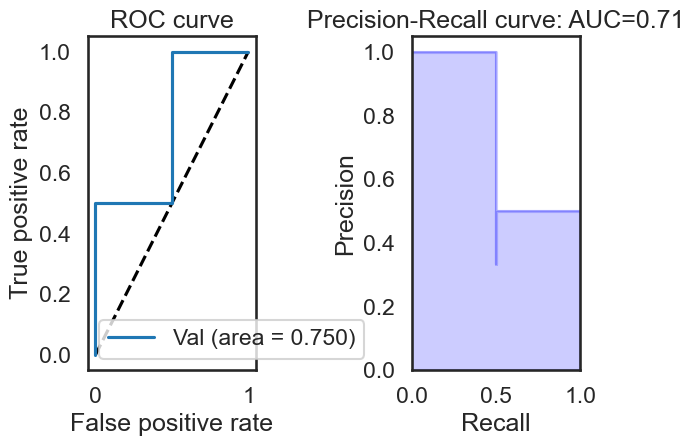

In [71]:
df = pd.DataFrame({'logits': logits_history, 'pred_label': pred_labels, 'label': true_labels})
df_test = pd.read_csv(os.path.join(config['data_dir'], "sample.csv"))

fig = plt.figure(1)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fpr, tpr, df_out = vote_score(df_test, logits_history, ax1)
rp80 = vote_pr_curve(df_test, logits_history, ax2)

output_eval_file = os.path.join(config['output_dir'], "eval_results.txt")
plt.tight_layout()
plt.show()

### Save inference information to output directory

In [72]:
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples
result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'RP80': rp80}
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

11/18/2022 02:43:35 - INFO - __main__ -   ***** Eval results *****
11/18/2022 02:43:35 - INFO - __main__ -     RP80 = 0.5
11/18/2022 02:43:35 - INFO - __main__ -     eval_accuracy = 0.8333333333333334
11/18/2022 02:43:35 - INFO - __main__ -     eval_loss = 0.5382883548736572
